## 5장 오차역전파법

In [1]:
# import modules

import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from PIL import Image
import pickle

### 5.4 단순한 계층 구현하기

In [2]:
# 5.4.1 곱셈 계층

class MulLayer:
    def __init__(self) -> None:
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x*y

        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy


In [3]:
apple = 100
apple_num = 2
tax = 1.1

# layers
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward propagation
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [4]:
# back propagation

dprice=1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


In [5]:
### 5.4.2  덧셈 계층

class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy


In [6]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


### 5.5 활성화 함수 계층 구현하기

In [7]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x<=0) # True, False로 구성된 넘파이 배열. 순전파 입력이 0보다 크면 False, 0보자 작으면 true를 저장한다.
        out = x.copy() # copy를 하게 되면, out은 numpy 배열이 된다.
        
        # numpy array에서 out[True] = 0이라는 의미는, out 속 모든 값을 0으로 만든다는 의미이다.
        # 아래 구체적인 실험이 있지만, out[self.mask] = 0은 self.mask 중 True에 해당하는 index에 있는 out 속 값을 0으로 바꾼다는 의미이다.
        out[self.mask] = 0 

        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [8]:
# out[self.mask] = 0 효과에 대한 실험

a = np.array([0.1,-0.1])
b = (a <= 0)

print(b)
print(a[b])
a[b] = 0
print(a[b])

[False  True]
[-0.1]
[0.]


In [9]:
# 5.5.2 Sigmoid 계층

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1/(1+np.exp(x))
        self.out = out

        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

In [10]:
# 5.6.2 Affine 계층
# 175쪽 그림을 보면 좀 더 와닿을 수 있다. 행렬에서 미분의 역이 어떻게 이루어지는지를 알 수 있다. 

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx

In [11]:
# 5.6.3 SoftmaxWithLoss

from functions import *

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # 소프트맥스의 출력
        self.t = None # 정답 레이블(원-핫 벡터)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx
    

In [12]:
# 5.7.2 오차역전파법을 적용한 신경망 구현하기

import sys, os
sys.path.append(os.pardir)
import numpy as np
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNetWithBackProp:
    def __init__(self, input_size, hidden_size, output_size,
                 weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = \
            Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = \
            Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
    
    # x : input data, t : label
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t / float(x.shape[0]))

        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x,t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads
    
    def gradient(self, x, t):
        # forward propagation
        self.loss(x, t)

        # backward propagation
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads
    



In [13]:
# 얘는 제대로 돌아가는지 검증해보자.

class ThreeLayerNetWithBackProp:
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size,
                 weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(hidden_size, hidden_size_2)
        self.params['b2'] = np.zeros(hidden_size_2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size_2, output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = \
            Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = \
            Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
    
    # x : input data, t : label
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t / float(x.shape[0]))

        return accuracy
    

    def gradient(self, x, t):
        # forward propagation
        self.loss(x, t)

        # backward propagation
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        grads['W3'] = self.layers['Affine3'].dW
        grads['b3'] = self.layers['Affine3'].db

        return grads

In [14]:
import sys, os
import numpy as np
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)
network = ThreeLayerNetWithBackProp(input_size=784, hidden_size=128, hidden_size_2=64, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size, 1)

# for i in range(iters_num):
#     batch_mask = np.random.choice(train_size, batch_size)
#     x_batch = x_train[batch_mask]
#     t_batch = t_train[batch_mask]

#     grad = network.gradient(x_batch, t_batch)

#     for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
#         network.params[key] -= learning_rate * grad[key]

#     loss = network.loss(x_batch, t_batch)
#     train_loss_list.append(loss)

#     if i % iter_per_epoch == 0:
#         train_acc = network.accuracy(x_train, t_train)
#         test_acc = network.accuracy(x_test, t_test)
#         train_acc_list.append(train_acc)
#         test_acc_list.append(test_acc)
#         print(train_acc, test_acc)

In [15]:
# # plot train loss

# plt_x = np.arange(0.0, float(len(train_loss_list)), 1.0)
# plt_y = np.array(train_loss_list)
# plt.plot(plt_x, plt_y)
# plt.show()

In [16]:
# 여기 데이터셋을 이용해서 학습을 진행해보자. 
def image_preprocessing(image: np.ndarray, batch_size):
    image = image.reshape(batch_size, -1)
    image = image.astype(np.float32)
    image = (image / 255)

    return image


def only_python_softmax(z :np.ndarray):
    z = z - np.max(z, axis=1, keepdims=True)
    y = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
    return y


def only_python_cross_entropy_loss(x_softmax:np.ndarray, label:np.ndarray):
    label = label.argmax(axis=1)
    batch_size = x_softmax.shape[0]
    return -np.sum( np.log(x_softmax[np.arange(batch_size), label] + 1e-7 ) ) / batch_size


class OnlyPythonLinearLayer:
    def __init__(self, input_size, output_size):
        self.weight = 0.01 * np.random.randn(input_size, output_size)
        self.bias = np.zeros(output_size)
        
        self.input = None
        self.weight_gradient = None
        self.bias_gradient = None

    def forward(self, input):
        self.input = input
        return np.dot(self.input, self.weight) + self.bias
    
    def backward(self, before_gradient):
        gradient = np.dot(before_gradient, self.weight.T)
        self.weight_gradient = np.dot(self.input.T, before_gradient)
        self.bias_gradient = np.sum(before_gradient, axis=0)

        return gradient


class OnlyPythonReLU:
    def __init__(self):
        self.is_zero = None

    def forward(self, x:np.ndarray):
        self.is_zero = (x<=0)
        y = x.copy()
        y[self.is_zero] = 0

        return y
    
    def backward(self, before_gradient):
        before_gradient[self.is_zero] = 0
        gradient = before_gradient

        return gradient


class OnlyPythonCrossEntrophyLoss:
    def __init__(self):
        self.loss = None
        self.x_softmax: np.ndarray = None
        self.label: np.ndarray = None

    def forward(self, x, label):
        self.label = label
        self.x_softmax = only_python_softmax(x)
        self.loss = only_python_cross_entropy_loss(self.x_softmax, self.label)

        return self.loss
    
    def backward(self):
        batch_size = self.label.shape[0]
        gradient = (self.x_softmax - self.label) / batch_size

        return gradient


class OnlyPythonThreeLayerNet:
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output, learning_rate=0.01):
        self.linear1 = OnlyPythonLinearLayer(n_input, n_hidden1)
        self.linear2 = OnlyPythonLinearLayer(n_hidden1, n_hidden2)
        self.linear3 = OnlyPythonLinearLayer(n_hidden2, n_output)
        self.softmaxlayer = OnlyPythonCrossEntrophyLoss()

        self.relu1 = OnlyPythonReLU()
        self.relu2 = OnlyPythonReLU()

        self.lr = learning_rate


    def forward(self, input):
        output = input
        output = self.linear1.forward(output)
        output = self.relu1.forward(output)
        output = self.linear2.forward(output)
        output = self.relu2.forward(output)
        output = self.linear3.forward(output)
        
        return output
    

    def loss(self, output, label):
        loss = self.softmaxlayer.forward(output, label)

        return loss
    
    
    # run with optimizer() after forward, loss run
    def backward(self):
        dy = self.softmaxlayer.backward()
        dy = self.linear3.backward(dy)
        dy = self.relu2.backward(dy)
        dy = self.linear2.backward(dy)
        dy = self.relu1.backward(dy)
        dy = self.linear1.backward(dy)
        

    # use SGD method
    def optimizer(self):
        self.backward()

        self.linear1.weight -= self.lr * self.linear1.weight_gradient
        self.linear1.bias -= self.lr * self.linear1.bias_gradient

        self.linear2.weight -= self.lr * self.linear2.weight_gradient
        self.linear2.bias -= self.lr * self.linear2.bias_gradient

        self.linear3.weight -= self.lr * self.linear3.weight_gradient
        self.linear3.bias -= self.lr * self.linear3.bias_gradient



In [17]:
only_python_n_input = 784
only_python_n_hidden1 = 128
only_python_n_hidden2 = 64
only_python_n_output = 10

only_python_lr = 0.01
only_python_epoch = 10000

only_python_net = OnlyPythonThreeLayerNet(only_python_n_input, 
                                          only_python_n_hidden1, 
                                          only_python_n_hidden2,
                                          only_python_n_output,
                                          only_python_lr)

only_python_train_loss_list = []
only_python_test_loss_list = []

In [18]:
from tqdm.notebook import tqdm

batch_counter = 0
for epoch in tqdm(range(only_python_epoch)):
    batch_mask = np.random.choice(train_size, batch_size)
    train_images = x_train[batch_mask]
    train_labels = t_train[batch_mask]

    output = only_python_net.forward(train_images)

    loss = only_python_net.loss(output, train_labels)
    only_python_train_loss_list.append(loss)

    if batch_counter % 100 == 0: 
        print(f"Loss {loss} at epoch {epoch} batch {batch_counter}")
        print(train_images.shape)
        print(train_labels.shape)
        # print(train_images[0])
        # print(train_labels[0])

    only_python_net.optimizer()

    # # test part
    # test_images = image_preprocessing(test_images, only_python_batch_size_test)
    
    # test_output = only_python_net.forward(test_images)
    # test_loss = only_python_net.loss(test_output, test_labels)
    # only_python_test_loss_list.append(test_loss)

    batch_counter += 1


  0%|          | 0/10000 [00:00<?, ?it/s]

Loss 2.302571838976034 at epoch 0 batch 0
(100, 784)
(100, 10)
Loss 2.3030721789843085 at epoch 100 batch 100
(100, 784)
(100, 10)
Loss 2.3039942690610915 at epoch 200 batch 200
(100, 784)
(100, 10)
Loss 2.3015383469328095 at epoch 300 batch 300
(100, 784)
(100, 10)
Loss 2.298585623952344 at epoch 400 batch 400
(100, 784)
(100, 10)
Loss 2.299341758437606 at epoch 500 batch 500
(100, 784)
(100, 10)
Loss 2.2993435087050327 at epoch 600 batch 600
(100, 784)
(100, 10)
Loss 2.300983411440041 at epoch 700 batch 700
(100, 784)
(100, 10)
Loss 2.3021558805515365 at epoch 800 batch 800
(100, 784)
(100, 10)
Loss 2.2987196303038355 at epoch 900 batch 900
(100, 784)
(100, 10)
Loss 2.304956418284768 at epoch 1000 batch 1000
(100, 784)
(100, 10)
Loss 2.2980593121173976 at epoch 1100 batch 1100
(100, 784)
(100, 10)
Loss 2.2956057734408124 at epoch 1200 batch 1200
(100, 784)
(100, 10)
Loss 2.300058131155817 at epoch 1300 batch 1300
(100, 784)
(100, 10)
Loss 2.3011707217795623 at epoch 1400 batch 1400
(

In [19]:
print(train_images.shape)

(100, 784)


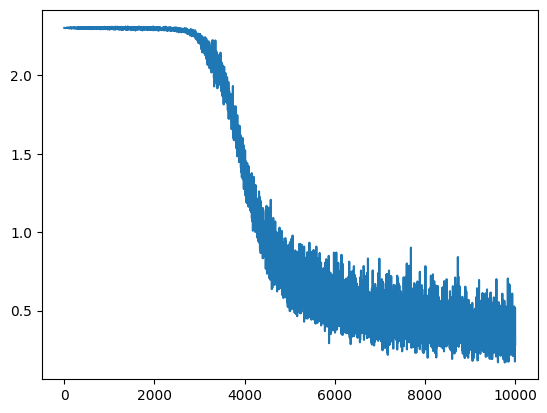

In [20]:
# plot training loss
plt_x = np.arange(0.0, float(len(only_python_train_loss_list)), 1.0)
plt_y = np.array(only_python_train_loss_list)
plt.plot(plt_x, plt_y)
plt.show()

In [21]:
# 5.7.3 오차역전파법으로 구한 기울기 검증하기

import sys, os
import numpy as np
from mnist import load_mnist

from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))




W1:2.0183102576967655e-10
b1:1.023138570569414e-09
W2:7.088396571609812e-08
b2:1.4233019042242389e-07


In [22]:
# 5.7.4 오차역전파법을 사용한 학습 구현하기

import sys, os
import numpy as np
from mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.1149 0.1154
0.7918166666666666 0.795
0.8790333333333333 0.883
0.89745 0.9015
0.9071666666666667 0.9112
0.9139666666666667 0.9155
0.9186833333333333 0.9203
0.9219666666666667 0.9248
0.9275333333333333 0.9282
0.9306166666666666 0.9311
0.93335 0.9324
0.9361166666666667 0.9362
0.9389166666666666 0.9381
0.9411 0.9415
0.94355 0.943
0.9456833333333333 0.9452
0.9474666666666667 0.9471


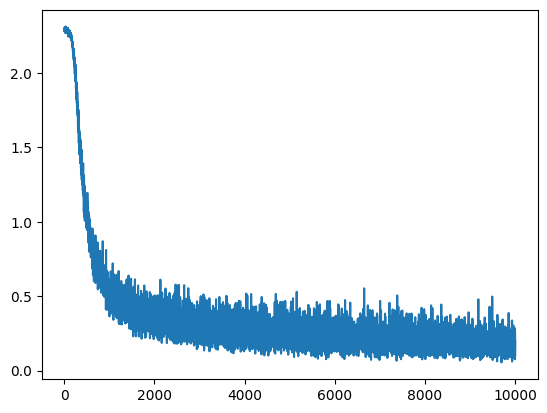

In [23]:
# plot train loss

plt_x = np.arange(0.0, float(len(train_loss_list)), 1.0)
plt_y = np.array(train_loss_list)
plt.plot(plt_x, plt_y)
plt.show()

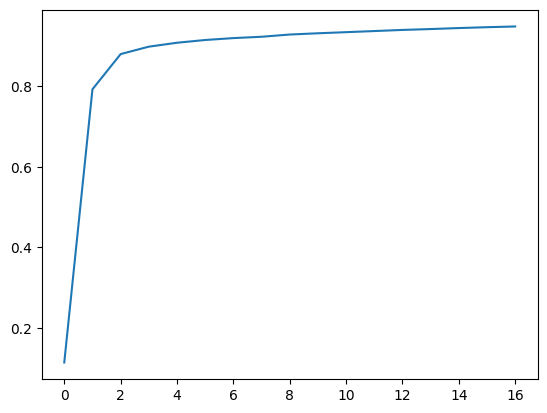

In [24]:
# plot train accuracy

plt_x = np.arange(0.0, float(len(train_acc_list)), 1.0)
plt_y = np.array(train_acc_list)
plt.plot(plt_x, plt_y)
plt.show()

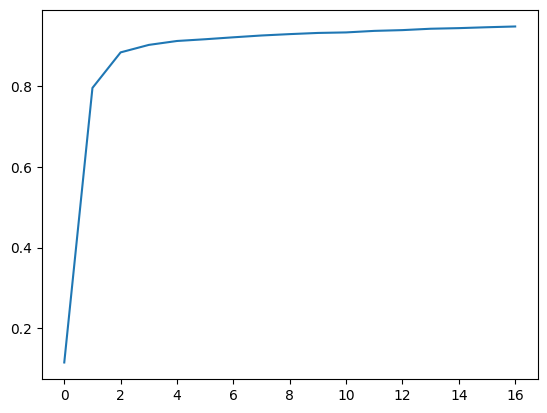

In [25]:
# plot test accuracy

plt_x = np.arange(0.0, float(len(test_acc_list)), 1.0)
plt_y = np.array(test_acc_list)
plt.plot(plt_x, plt_y)
plt.show()